# 2. Feature Engineering

In this notebook we will transform (scale/normalize,encode categorical features, feature cross), create new features and check feature importance.

At the end of this notebooks we will have the data ready to start training a ML model.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Load dataframe

In [3]:
df = pd.read_feather(path="EDA_dataframe.feather")
print(df.head())

             Datetime  year  month  day  hour  PM2.5  PM10  SO2   NO2     CO  \
0 2013-03-01 00:00:00  2013      3    1     0    9.0   9.0  3.0  17.0  300.0   
1 2013-03-01 01:00:00  2013      3    1     1    4.0   4.0  3.0  16.0  300.0   
2 2013-03-01 02:00:00  2013      3    1     2    7.0   7.0  NaN  17.0  300.0   
3 2013-03-01 03:00:00  2013      3    1     3    3.0   3.0  5.0  18.0    NaN   
4 2013-03-01 04:00:00  2013      3    1     4    3.0   3.0  7.0   NaN  200.0   

     O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  
0  89.0  -0.5  1024.5 -21.4   0.0  NNW   5.7  
1  88.0  -0.7  1025.1 -22.1   0.0   NW   3.9  
2  60.0  -1.2  1025.3 -24.6   0.0  NNW   5.3  
3   NaN  -1.4  1026.2 -25.5   0.0    N   4.9  
4  84.0  -1.9  1027.1 -24.5   0.0  NNW   3.2  


## Encode Cayegorical Feature - Wind direction

The variable **wd** represents wind direction, and normally is divided into 16 categories:N, NNE, NE, ENE, E, ESE, SE, SSE, S, SSW, SW, WSW, and W.

In our case (in this dataset), the authors thought it was a good idea to group these 16 categories into major 4 categories:
1.NW:
WNW, NW, and NNW. This means, we divide the 360º into 16 slices obtaining the 16 cardinal directions. In order to transform this variable into a numerical variable I decided to divide the full 360º into 16 sections of 22.5º each, and assign each slice to the respective category. The end result is the following:

1. **0º     - North (N)**
2. **22.5º  - North-Northeast (NNE)**
3. **45º    - NorthEast (NE)**
4. **67.5º  - East-Northeast (ENE)**
5. **90º    - East (E)**
6. **112.5º - East-Southeast (ESE)**
7. **135º   - Southeast (SE)**
8. **157.5º - South-Shoutheast (SSE)**
9. **180º   - South (S)**
10. **202.5º- South-Southwest (SSW)**
11. **225º  - Southwest(SW)**
12. **247.5º- West-Southwest (WSW)**
13. **270º  - West (W)**
14. **292.5º- West-Northwest (WNW)**
15. **315º  - Northwest (NW)**
16. **337.5º- Nort-Northwest (NNW)**

wd
E      3564
ENE    3861
ESE    2706
N      1865
NE     3540
NNE    1928
NNW    1693
NW     2466
S      1547
SE     1880
SSE    1402
SSW    1953
SW     2481
W       984
WNW    1347
WSW    1769
Name: wd, dtype: int64


<AxesSubplot: >

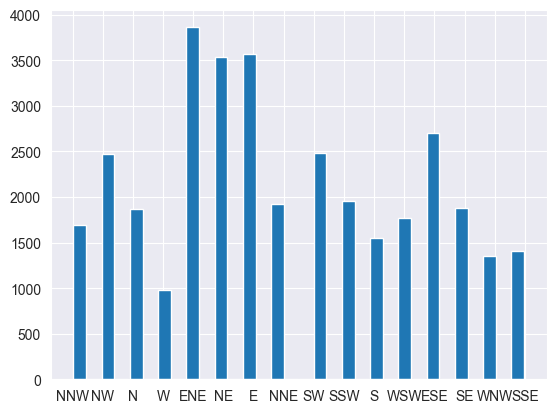

In [4]:
print(df.groupby("wd")["wd"].count())
df["wd"].hist(rwidth=0.9,bins=32)

In [5]:
#putting it into code

wind_dict = {"N":0,
             "NNE":22.5,
             "NE":45,
             "ENE":67.5,
             "E":90,
             "ESE":112.5,
             "SE":135,
             "SSE":157.5,
             "S":180,
             "SSW":202.5,
             "SW":225,
             "WSW":247.5,
             "W":270,
             "WNW":292.5,
             "NW":315,
             "NNW":337.5
             }

df["wd"] = df["wd"].replace(wind_dict).astype(float)

In [6]:
print(df["wd"].unique())
print(df.groupby("wd")["wd"].count())

[337.5 315.    0.  270.   67.5  45.   90.   22.5 225.  202.5 180.  247.5
 112.5 135.  292.5 157.5   nan]
wd
0.0      1865
22.5     1928
45.0     3540
67.5     3861
90.0     3564
112.5    2706
135.0    1880
157.5    1402
180.0    1547
202.5    1953
225.0    2481
247.5    1769
270.0     984
292.5    1347
315.0    2466
337.5    1693
Name: wd, dtype: int64


## Dealing with Missing Values





As we've seen in the EDA notebook we have some missing values, but overall less than 10% per variable.

There are many strategies when dealing with missing values: filling with the mean/mode/median, delete entries when data is missing, using the last available value, or even linear,polynomial, or spline interpolation.

We choose to use spline interpolation because when dealing with time-series data, as in our case, we should impute taking into account the previous as future values available. And assuming the relation between past and future values is a good trade-off between correctness and simplicity.

Now, this should work when we have only a few entries missing at a time, let's say 1-5. But when we have a big block of entries missing (like we have in variables **CO** and **O3**) other, more powerful, techniques. As such, I decided to use an ARIMA model to try to predict those big gaps of missing data. I thought it was a better option/alternative than to lose about 5000 data points (about 20% of the total data). We would rely on a model to make inputs to our future models, but it was a compromise between losing so much data and having slightly worse inputs.




<AxesSubplot: >

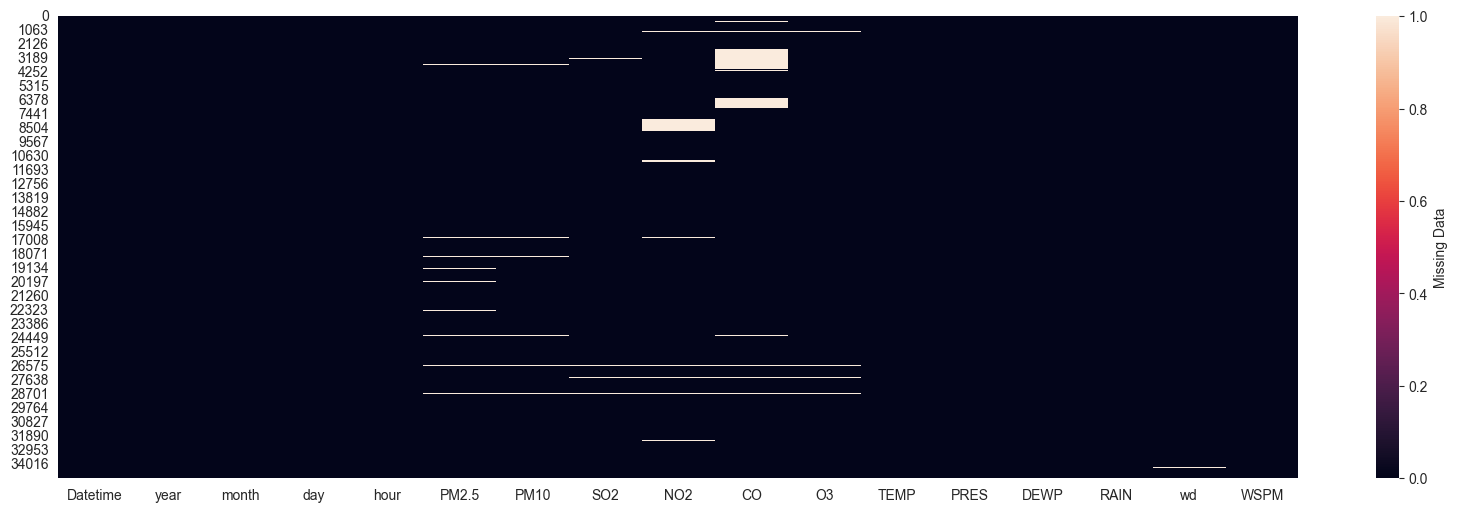

In [7]:
plt.figure(figsize=(20,6))
sns.heatmap(df.isna(),cbar_kws={'label': 'Missing Data'})

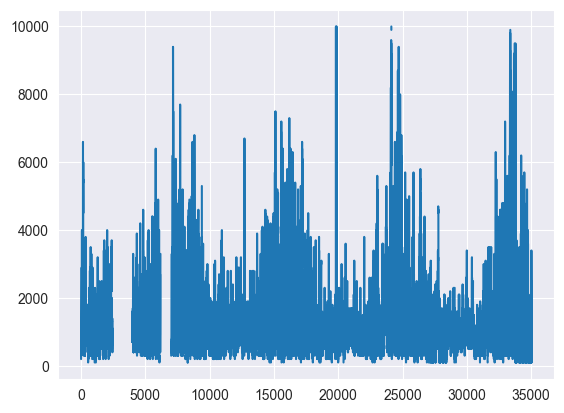

<AxesSubplot: >

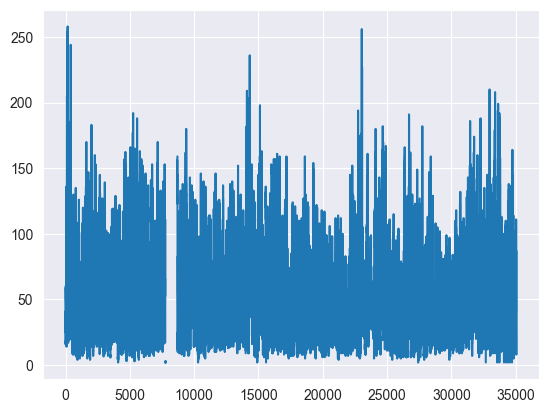

In [8]:
df["CO"].plot()
plt.show()
df["NO2"].plot()

In [9]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

test_df = df.drop(columns=["Datetime","PM2.5","PM10"])

cont_feats = [col for col in test_df.columns if test_df[col].dtype != object]
print(cont_feats)

iter_inputer = IterativeImputer(random_state=42,min_value=0,max_iter=30)
iter_inputed = iter_inputer.fit_transform(test_df[cont_feats])
df_iter_inputed = pd.DataFrame(iter_inputed,columns=cont_feats)



['year', 'month', 'day', 'hour', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']


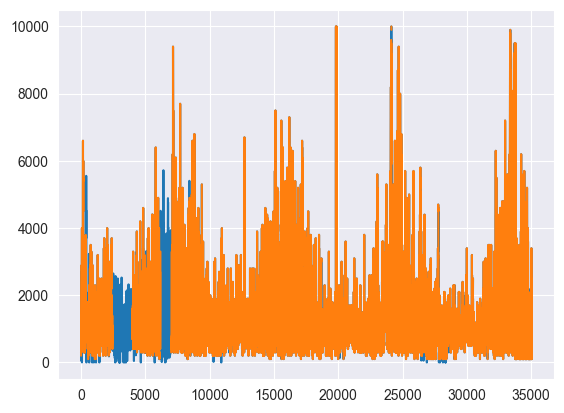

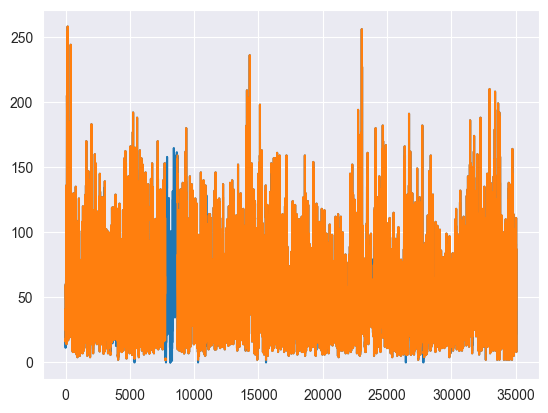

In [10]:
df_iter_inputed["CO"].plot()
df["CO"].plot()
plt.show()
df_iter_inputed["NO2"].plot()
df["NO2"].plot()
plt.show()

In [16]:
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor(n_estimators=5,max_depth=15,bootstrap=True,max_samples=0.8,n_jobs=2,random_state=42)

tolerance=1e-2
imputer = IterativeImputer(random_state=42,estimator=estimator,max_iter=25,tol=tolerance,min_value=0)
lol = iter_inputer.fit_transform(test_df[cont_feats])
coiso = pd.DataFrame(lol,columns=cont_feats)



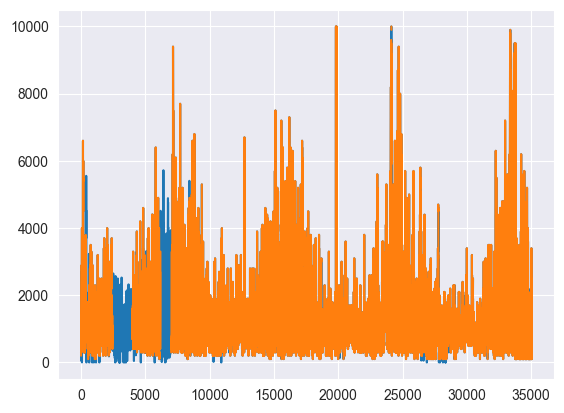

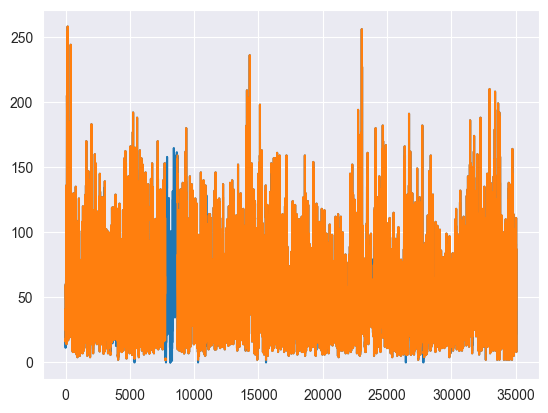

In [20]:
coiso["CO"].plot()
df["CO"].plot()
plt.show()
coiso["NO2"].plot()
df["NO2"].plot()
plt.show()